# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [ ]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
import nltk
nltk.download('brown')
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from collections import Counter, defaultdict

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package brown to /Users/clee/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:
# add any additional libaries you need here
import matplotlib
from collections import Counter

In [10]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [11]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [12]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [ ]:
df['category'].value_counts()

category
news          44
hobbies       36
government    30
romance       29
editorial     27
Name: count, dtype: int64

In [14]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

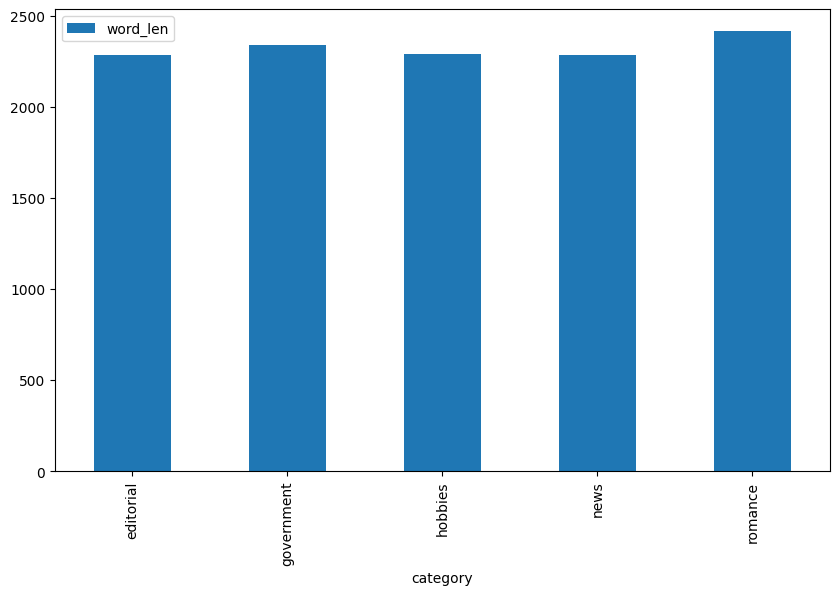

In [17]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [18]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/clee/github/ads-tm-topic-modeling/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [19]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: `count_text_vectors` holds a CountVectorizer matrix where each row represents a document and each column represents the count of a particular token. `rfidf_text_vectors` holds a TFIDFVectorizer matrix where each row represents a document and each column is a the product of a token's term frequency and its inverse document frequency. The TF-IDF scores range from 0 to infinity where a higher score indicates that the token is highly relevant to a specific document.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [20]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [21]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [ ]:
# count how many documents were assigned to each topic
topic_list = []
nmf_most_likely_topics = W_text_matrix.argmax(axis=1)
for topic in nmf_most_likely_topics:
    topic_list.append(topic)
topic_counts = Counter(topic_list)
print(topic_counts)

Counter({2: 65, 1: 41, 0: 32, 3: 18, 4: 10})


In [47]:
topic_category_df = pd.DataFrame({
    'nmf_topic': nmf_most_likely_topics,
    'category': df['category']
})

# [Disclaimer] This code block was generated by Github CoPilot to get a better breakdown of topics by Brown category.
# Tally the Brown categories within each NMF topic
topic_category_counts = topic_category_df.groupby('nmf_topic')['category'].value_counts().unstack(fill_value=0)
print(topic_category_counts)

category   editorial  government  hobbies  news  romance
nmf_topic                                               
0                 20           4        0     8        0
1                  4           0        8     0       29
2                  2          26       26    11        0
3                  0           0        1    17        0
4                  1           0        1     8        0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: 
- Topic 0 is likely `editorial` having captured 20 documents, but there is overlap with `news` (8). 
- Topic 1 is likely `romance` (29), but there is some overlap with `hobbies` (8) and `editorial` (4).
- Topic 2 is highly confused between `government` (26), `hobbies` (26) and `news` (11).
- Topic 3 is likely `news` (17) and almost none in the other categories.
- Topic 4 is weakly associated with `news` (8) but has low capture across all the categories.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [48]:
lsa_text_model = TruncatedSVD(n_components=5, random_state=42)
lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)

# Assign each document to the topic with the highest absolute value in the LSA matrix
lsa_most_likely_topics = np.abs(lsa_text_matrix).argmax(axis=1)

# Tally the Brown categories within each LSA topic
lsa_topic_category_df = pd.DataFrame({
    'lsa_topic': lsa_most_likely_topics,
    'category': df['category']
})
lsa_topic_category_counts = lsa_topic_category_df.groupby('lsa_topic')['category'].value_counts().unstack(fill_value=0)
print(lsa_topic_category_counts)

category   editorial  government  hobbies  news  romance
lsa_topic                                               
0                 27          21       25    33       21
1                  0           7        0     0        8
2                  0           2       11     0        0
3                  0           0        0     4        0
4                  0           0        0     7        0


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model does poorly at separating the documents. It assigned 117 documents to topic 0, while showing only weak associatations for the others.

In [49]:
# call display_topics on your model
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


Q: What is your interpretation of the display topics output? 

A: The top tokens associated with each topic are not very distinct compared to the NMF model. For example, the token "mrs" appears in the top 5 words for topics 0, 2, and 3. It also seems to be weighting fairly common tokens like 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [59]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_text_model.fit(count_text_vectors)


LatentDirichletAllocation(n_components=5, random_state=42)

In [60]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


In [ ]:
# Assign each doc to the most likely topic from LDA model
lda_most_likely_topics = lda_text_model.transform(count_text_vectors).argmax(axis=1)

lda_topic_category_df = pd.DataFrame({
    'lda_topic': lda_most_likely_topics,
    'category': df['category']
})

# Tally the Brown categories within each LDA topic
lda_topic_category_counts = lda_topic_category_df.groupby('lda_topic')['category'].value_counts().unstack(fill_value=0)
print(lda_topic_category_counts)

category   editorial  government  hobbies  news  romance
lda_topic                                               
0                  3           0       16     9        0
1                  1          20       14     3        0
2                 22           2        1    31        0
3                  0           8        3     1        0
4                  1           0        2     0       29


Q: What inference do you draw from the displayed topics for your LDA model? 

A: 
- Topic 0 is most likely associated with `hobbies` as words like "home" and "game" are present.
- Topic 1 is most likely `editorial` since the word "state," "development," and "states" are weighed heavily.
- Topic 2 is likely `government` since the word "president," "mr," and "said" are so prominent.
- Topic 3 is likely `news` as it is more general than either topic 1 or 2
- Topic 4 is likely `romance` given the strength of the word "man" and other casual words like "old" and "good"

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: The LDA model seems to have good separation for the `romance` category, but still struggles to differentiate `government`, `editorial`, and `news`.
- Topic 0 leans towards `hobbies` (16), but also has overlap with `news` (9). 
- Topic 1 leans towards `government` (20), but it also has overlap with `hobbies` (14).
- Topic 2 includes mostly news (31) and editorial (29), which makes sense since editorials are a subset of news.
- Topic 3 is the most sparse, but consists of a majority of government docs (8) and some hobby docs (3).
- Topic 4 consists of mostly `romance` documents.

In [57]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [58]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: 
- Based on the visualization, Topic 1 is associated with `hobbies` given the high relevance words such as "game," "season," and "ball." 
- The high salience of "president," "political," and "nucler" indicate that Topic 3 is related to `government` as opposed Topic 2 (news) which include more general words such as "state," "development," and "program". 
- We can see in the scatterplot, that Topic 2, 3, and 4 have high overlap, but Topic 2's most relevant tokens include "state," "development," and "programs" which would indicate that Topic 2 is most associated with `editorial`. In comparison, Topic 4's most relevant tokens are "feed," and "general," and "business" suggesting it is more related to general `news`.
- Topic 5 is clearly associated with the `romance` category based its obvious separation in the scatterplot and its most relevant terms being the most informal.
